<center>
<h2>Texmining 2021</h2>
<h3>Práctico: Clustering de palabras</h3>
</center>
</left>
<h3>Alumno: Martín Hunziker</h3>


In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import pickle
import nltk
import os
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance
from sklearn.feature_extraction import DictVectorizer


### Lectura de datos y pipeline de spacy

In [2]:
nlp = spacy.load("es_core_news_sm")
lemmatizer = nlp.get_pipe("lemmatizer")
print(lemmatizer.mode)  # 'rule'

rule


In [4]:
filename = "lavoztextodump.txt"
text_file = open(filename, "r", encoding = 'utf-8-sig')
dataset = text_file.read()
text_file.close()

Para perfeccionar la lematización del spacy si trabajará con la lista de lematiazion del site:
https://github.com/michmech/lemmatization-lists


In [5]:
   
lemma_file = open("lemmatization-es.txt", "r",encoding = 'utf-8-sig')
lemma_raw = lemma_file.read()
lemma = lemma_raw.split("\n")

lemma_dict = {}
for pair in lemma:
    w = pair.split("\t")
    if len(w) == 2:
        lemma_dict[w[1]] = w[0]
        
def lemmatize(word):
    if word in lemma_dict:
        word = lemma_dict[word]
    return word


In [6]:
len(dataset)

34140489

### Leemos parcialmente el corpus por limitación de memoria

In [26]:
nlp.max_length = 10000010
doc = nlp(dataset[0:10000000])

### Criterios de selección de palabras del corpus

1. Solamente consideraremos las oraciones de largo mayor a 10
2. Consideremos las palabras alfabéticas
3. Eliminamos las palabras que sean números
4. Definimos Límites de cantidad máxima de palabras con la variables qPalabraMax
 

In [27]:
sents = [sent for sent in doc.sents if len(sent) > 10]

words = []
words_lemma = []
for sent in sents:
    for word in sent:
        if word.is_alpha:
            words.append(word)
            words_lemma.append(lemmatize(word.lemma_))
            
counts = Counter(words_lemma)

Hacemos el histograma de las 50 lemmas más coumnes para observar la distribución

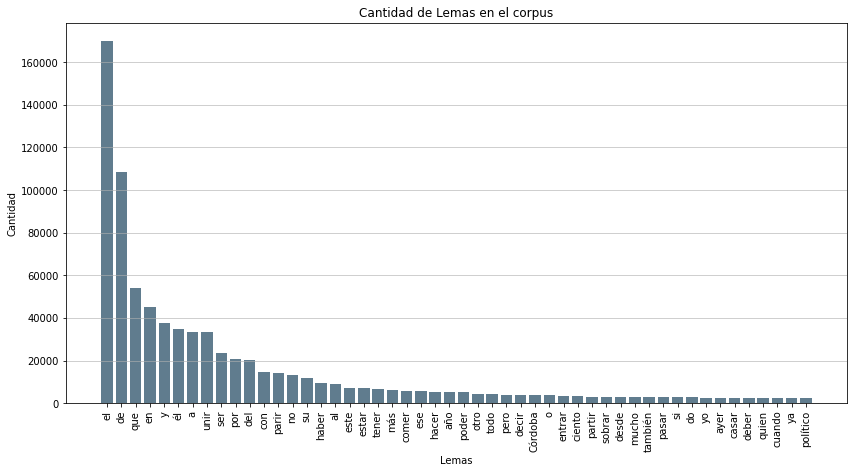

In [101]:
word_comm=pd.DataFrame(counts.most_common(10000))

plt.figure(figsize=(14, 7))

plt.bar(word_comm[0][0:50], word_comm[1][0:50],color='#607c8e',)

plt.title('Cantidad de Lemas en el corpus')
plt.xlabel('Lemas')
plt.ylabel('Cantidad')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=90)

plt.show()

Creamos un diccionario de palabras considerando las que ocurren mas veces:
   1. ocurren pocas veces (ranking 500)
   2. son numeros
   
y le adicionamos los features de cada vez que aparece.

Los features considerados son:

 * Part-Of-Speech POS word.pos_ (ADJ: adjective, ADP: adposition, ADV: adverb, AUX: auxiliary verb, CONJ: coordinating conjunction, DET: determiner, INTJ: interjection, NOUN: noun, NUM: numeral, PART: particle, PRON: pronoun,PROPN: proper noun,PUNCT: punctuation, SCONJ: subordinating conjunction, SYM: symbol, VERB: verb, X: other)
 * Dependencia semántica entre las palabras (word.dep_)
 * Morfología de la palabra
 * Agregamos los contextos, sin orden (ventana de 1 palabra).


In [141]:
limiteW=word_comm[1][2000] 
limiteW

75

In [142]:
dicc = {}
list_dicc = {}
word_id = 0
qPalabraMax = limiteW  
qPalabraConjMax = limiteW /4

for word in words:
    #print(word)
    w = lemmatize(word.lemma_)
    #print(word,word.is_alpha, not(str.isdigit(w)) , counts[w],counts[w] < qPalabraMax)
    if (word.is_alpha and counts[w] > qPalabraMax):
        if not w in dicc:
            features = {}
        else:
            features = dicc[w]
            
            
        pos = "POS__" + word.pos_
        if not pos in features:
            features[pos] = 0
        features[pos] += 1

        dep = "DEP__" + word.dep_
        if not dep in features:
            features[dep] = 0
        features[dep] += 1

        morf = "MRF__" + str(word.morph)
        if not morf in features:
            features[morf] = 0
        features[morf] += 1
        
        # Contexto
        if not word.i == 0:
            context_izq = doc[word.i - 1]
            c_izq = lemmatize(context_izq.lemma_)
            if context_izq.is_alpha and counts[c_izq] > qPalabraConjMax:
                if str.isdigit(c_izq):
                    c_izq = "NUM__"
                if not c_izq in features:
                    features[c_izq] = 0
                features[c_izq] += 1

        if not word.i < len(doc):
            context_der = doc[word.i + 1]
            c_der = lemmatize(context_der.lemma_)
            if context_der.is_alpha and counts[c_der] > qPalabraConjMax:
                if str.isdigit(c_der):
                    c_der = "NUM__"
                if not c_der in features:
                    features[c_der] = 0
                features[c_der] += 1

        tripla = "TRIPLA__" + w + "__" + word.lemma_ + "__" + word.dep_ + "__" + lemmatize(word.head.lemma_)
        if not tripla in features:
            features[tripla] = 0
        features[tripla] += 1

        word_id += 1

        dicc[w] = features


In [143]:
#dicc

Separamos las palabras y sus features

In [144]:
features = []
key_words = {}
wid = 0
for d in dicc:
    if len(d) > 0:
        key_words[d] = wid
        wid += 1
        features.append(dicc[d])

In [145]:
## guardamos los archivos a pickle

filename = "trained/dicc.pickle"
fileObj = open(filename, 'wb')
pickle.dump(dicc, fileObj)
fileObj.close()

filename = "trained/features.pickle"
fileObj = open(filename, 'wb')
pickle.dump(features, fileObj)
fileObj.close()

filename = "trained/keys.pickle"
fileObj = open(filename, 'wb')
pickle.dump(key_words, fileObj)
fileObj.close()

Vectorizamos y normalizamos la matriz por filas

In [146]:
v = DictVectorizer(sparse=False)
matrix = v.fit_transform(features)
matrix_normed = matrix / matrix.max(axis=0)

#### Reducimos la dimensionalidad quitando aquellas columnas que tengan poca varianza

In [147]:
variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))

In [148]:
VarianzaMin = 0.001
red_matrix = np.delete(matrix_normed, np.where(variances < VarianzaMin), axis=1)

#### Reducimos la dimensionalidad aplicando el t-distributed Stochastic Neighbor Embedding.

In [149]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
matrix_dicc2d = tsne.fit_transform(red_matrix)

In [150]:
pointsspacy = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, matrix_dicc2d[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y"]
)

(array([-100.,  -75.,  -50.,  -25.,    0.,   25.,   50.,   75.,  100.,
         125.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

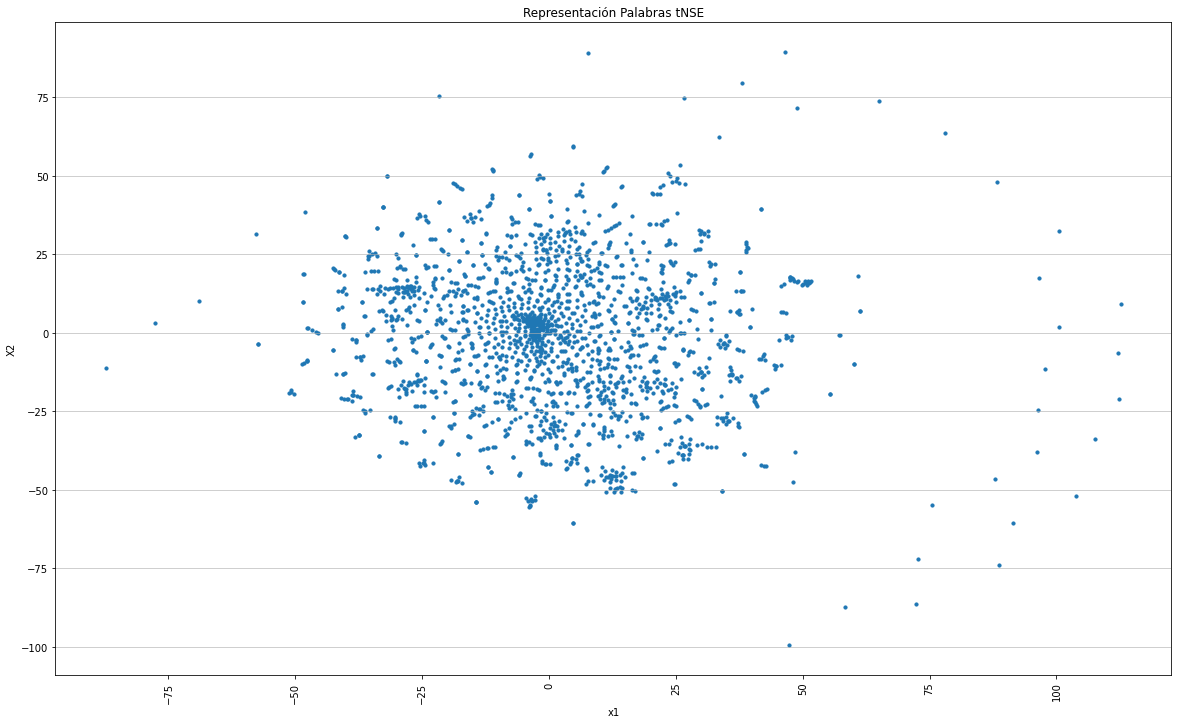

In [151]:
pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))
plt.title('Representación Palabras tNSE')
plt.xlabel('x1')
plt.ylabel('X2')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=90)


In [152]:
def plot_region(x_bounds, y_bounds):
    slice = pointsspacy[
        (x_bounds[0] <= pointsspacy.x) &
        (pointsspacy.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointsspacy.y) &
        (pointsspacy.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

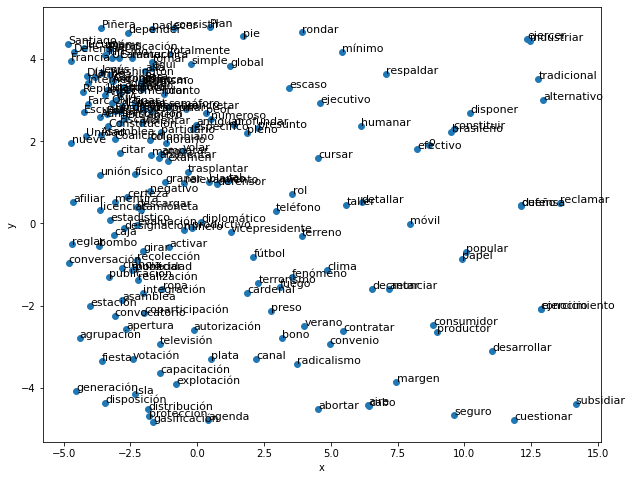

In [153]:
plot_region(x_bounds=(-5, 15), y_bounds=(-5, 5))

In [154]:
def clustering(k):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(red_matrix, True)
    return clusters

In [155]:
c20 =  clustering(20)
#c100 = clustering(100)
#c150 = clustering(150)


C:\Users\mhunz\.conda\envs\NLP\lib\site-packages\nltk\cluster\util.py:131: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


In [126]:
# Exportando a pickle

filename = "trained/c50.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c50, fileObj)
fileObj.close()

filename = "trained/c100.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c100, fileObj)
fileObj.close()

filename = "trained/c150.pickle"
fileObj = open(filename, 'wb')
pickle.dump(c150, fileObj)
fileObj.close()

In [156]:

clusters = c20
pointscluster = pd.DataFrame(
    [
        (word, coords[0], coords[1], cluster)
        for word, coords, cluster in [
            (word, matrix_dicc2d[key_words[word]], clusters[key_words[word]])
            for word in key_words
        ]
    ],
    columns=["word", "x", "y", "cluster"]
)

<AxesSubplot:xlabel='x', ylabel='y'>

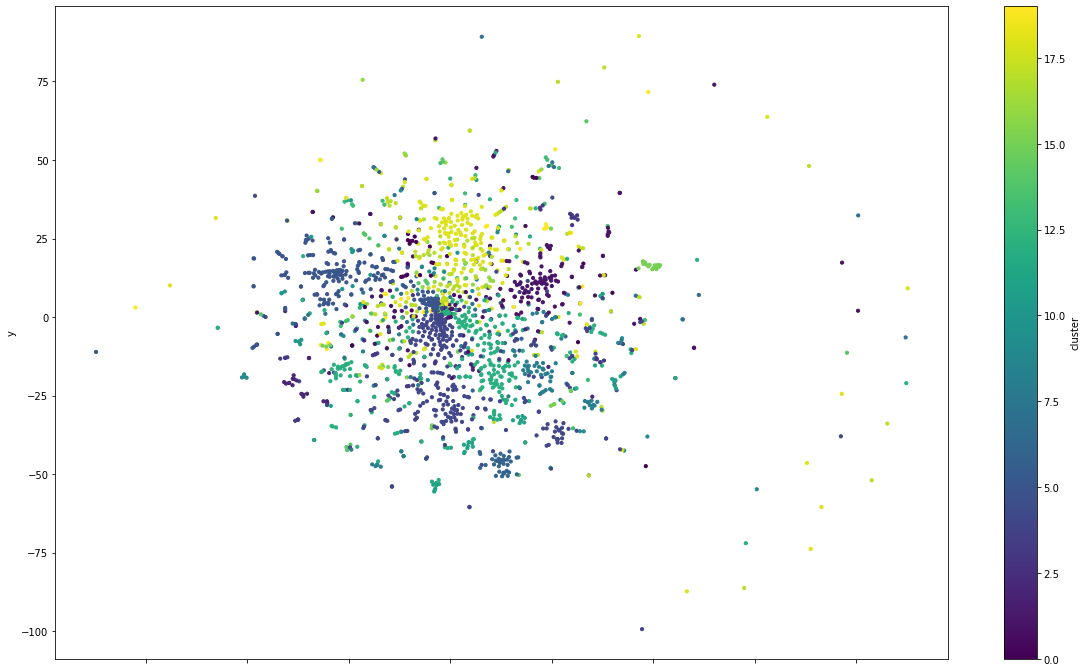

In [157]:
pointscluster.plot.scatter(x='x', y='y', c='cluster', cmap='viridis', s=10, figsize=(20, 12))

In [158]:
def plot_region_cluster(x_bounds, y_bounds):
    slice = pointscluster[
        (x_bounds[0] <= pointscluster.x) &
        (pointscluster.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointscluster.y) &
        (pointscluster.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', c='cluster', cmap='viridis', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

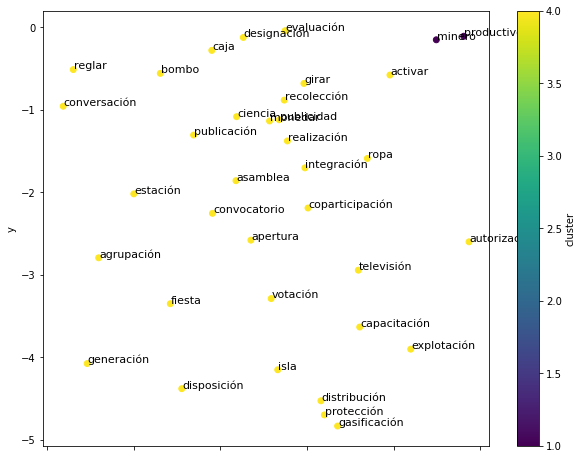

In [166]:
plot_region_cluster(x_bounds=(-5, 0), y_bounds=(-5, 0))

In [167]:
# Stopwords
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["de"]]]
print(printer)

['y', 'de', 'juntar', 'pero', 'parir', 'también', 'o', 'aunque', 'completar', 'ni', 'donde', 'antes', 'e', 'extranjero', 'histórico', 'tender', 'bajar', 'según', 'cordobés', 'mínimo', 'físico', 'directamente', 'En', 'argentino', 'definitivo', 'adentrar', 'francés', 'electrónico', 'directo', 'chino', 'humano', 'chileno', 'urbano', 'humanar', 'español', 'tecnológico', 'turístico', 'cubano']


In [168]:
# Verbos
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["ayudar"]]]
print(printer)

['lograr', 'pensar', 'hablar', 'vivir', 'después', 'ver', 'ayudar', 'trabajar', 'crecer', 'creer', 'faltar', 'poner', 'decidir', 'tomar', 'sumar', 'volver', 'advertir', 'saber', 'llegar', 'empezar', 'leer', 'dar', 'morir', 'construir', 'quedar', 'desaparecer', 'esperar', 'pelear', 'evitar', 'mediano', 'participar', 'generar', 'tornar', 'subrayar', 'matar', 'comenzar', 'cumplir', 'encontrar', 'algo', 'suceder', 'subir', 'salvar', 'implicar', 'funcionar', 'apuntar', 'recuperar', 'impedir', 'ubicar', 'existir', 'corresponder', 'modificar', 'perder', 'extender', 'ampliar', 'aplicar', 'permitir', 'profundizar', 'disminuir', 'afectar', 'vender', 'sacar', 'cualquiera', 'intervenir', 'Marcos', 'discutir', 'fijar', 'recurrir', 'adulto', 'aclarar', 'intentar', 'continúar', 'prestar', 'arreglar', 'ahorrar', 'ejercer', 'avanzar', 'favorecer', 'provocar', 'jugar', 'comprender', 'aprender', 'actuar', 'concretar', 'atravesar', 'nadie', 'invertir', 'exportar', 'conseguir', 'afrontar', 'alcanzar', 'red

In [169]:
# Politica
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["Giacomino"]]]
print(printer)

['Manuel', 'Belgrano', 'Alejandro', 'Jerónimo', 'Luis', 'Cabrera', 'Educación', 'Unidos', 'Córdoba', 'Nicolás', 'Villa', 'Rodríguez', 'María', 'A', 'Ley', 'Provincial', 'Ciencias', 'Facultad', 'De', 'Capital', 'Cruz', 'Santa', 'Alta', 'Gracia', 'Alfredo', 'Argentina', 'Internacional', 'Provincia', 'Nación', 'Mundial', 'Nacional', 'Carlos', 'Paz', 'San', 'Francisco', 'Río', 'Cuarto', 'Ejecutivo', 'Justicia', 'Secretaría', 'Ambiente', 'Santiago', 'Sociedad', 'Legislatura', 'Comisión', 'Asuntos', 'Universidad', 'Suprema', 'UNC', 'Casa', 'Francia', 'España', 'Roberto', 'José', 'Marina', 'Garzón', 'República', 'Pablo', 'General', 'Escuela', 'mientras', 'Grahovac', 'Martín', 'Alemania', 'Cristina', 'Fernández', 'Kirchner', 'Comercio', 'Interior', 'alemán', 'Europea', 'Sur', 'Israel', 'Servicios', 'Voz', 'Afip', 'Anses', 'Judicial', 'Néstor', 'Buenos', 'Aires', 'Cívico', 'Juez', 'Oscar', 'Aguad', 'Díaz', 'Federal', 'Gustavo', 'Moyano', 'CGT', 'Hugo', 'asimismo', 'Trabajo', 'Juan', 'Víctor', '

In [170]:
# Importantes
printer = [word for word in key_words if clusters[key_words[word]] == clusters[key_words["importante"]]]
print(printer)

['gran', 'nuevo', 'grande', 'común', 'permanente', 'personal', 'suficiente', 'general', 'necesario', 'importante', 'secundario', 'escolar', 'estudiante', 'estudiantil', 'ex', 'mejor', 'solo', 'defensa', 'diverso', 'adolescente', 'pendiente', 'joven', 'docente', 'diferente', 'representante', 'social', 'responsable', 'difícil', 'fuerte', 'frecuentar', 'actual', 'nacional', 'internacional', 'superior', 'menor', 'mundial', 'provincial', 'anterior', 'público', 'natural', 'cultural', 'profesional', 'radical', 'oficial', 'básico', 'habitante', 'homosexual', 'simple', 'ambiental', 'universitario', 'cordobé', 'dirigente', 'verde', 'productivo', 'industrial', 'primario', 'original', 'principal', 'gratuito', 'periodista', 'formal', 'sexual', 'particular', 'previo', 'frigorífico', 'administrativo', 'comercial', 'popular', 'especial', 'externo', 'peor', 'ilegal', 'central', 'eventual', 'vigente', 'local', 'comerciante', 'institucional', 'municipal', 'numeroso', 'legal', 'real', 'enorme', 'igual', '